In [15]:
# Importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import matplotlib.patches as Patches
import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [16]:
#Upload the data from the COVID19Tracking project GitHub page

#Upload the state-by-state USA data
url_states = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
covid19_usa_states_daily = pd.read_csv(url_states)
#Upload the USA data
url_usa = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/us_daily.csv'
covid19_usa_daily = pd.read_csv(url_usa)

In [17]:
#Filter the data
#Change the column 'states', which previously tracked the number of infected states, into a column
#'state', all called USA. In this way USA will be read as one of the possible states for which one can 
# plot the available data, while in fact it will report the cumulative data, summed over all the states
covid19_usa_daily.columns = ['state' if x=='states' else x for x in covid19_usa_daily.columns]
covid19_usa_daily.state = 'USA'

#In this way the state-by-state and the federal DataFrame have the same columns. 

#Invert the direction of time for the federal database, which is ordered from the oldest to today, top to bottom.
covid19_usa_daily = covid19_usa_daily.iloc[::-1]
#In this way it is ordered as the state-wise database



#The states databases has some NaNs, for example in the number of deaths in states where it is zero. 
#So we fill it with a zero
covid19_usa_states_daily = covid19_usa_states_daily.fillna(0)
covid19_usa_daily = covid19_usa_daily.fillna(0)

#######STANDING ISSUE#############################
#total IS NOT EQUAL TO positive+negative+pending
#covid19_usa_daily['total']==(covid19_usa_daily['positive']+covid19_usa_daily['negative']+covid19_usa_daily['pending'])
#The difference is small so, for now, we proceed
#################################################

#Drop the dateChecked column from the state-wise database
covid19_usa_states_daily=covid19_usa_states_daily.drop(columns='dateChecked')

#Defin the posNeg column for the states database, to make it consistent with the USA database
covid19_usa_states_daily['posNeg']=covid19_usa_states_daily.positive+covid19_usa_states_daily.negative

#Reorder the columns in the states database, again for consistency with the USA database
covid19_usa_states_daily = covid19_usa_states_daily[['date','state','positive','negative','posNeg','pending','death','total']]


#Append the USA dataFrame to the state-wise dataFrame to create the actual dataFrame we will use
covid19_USA = covid19_usa_states_daily.append(covid19_usa_daily, ignore_index=True)

#Turn the string data into a datetime format, necessary to fit the data
covid19_USA['date']=pd.to_datetime(covid19_USA['date'],format="%Y%m%d")

In [18]:
#Seaborn setup for plots
sns.set(rc={'figure.figsize':(11, 7)})

### Here we load the previously fitted data and plot both data and fit

- **date** = date of observation
- **states** number of states with covid-19 cases
- **positive** number of tests with positive result
- **negative** number of tests with negative result
- **posNeg** sum of positive and negative
- **pending** number of tests with pending result
- **death** number of death cases
- **total** total number of cases

Names of the states:
- ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA","HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY","USA"]

In [19]:
#Function to plot the indicators in "indicator_to_plot" for a list of regions specificed in "region_list"
def plot_data(states_to_plot,indicators_to_plot,x_lim=None,y_lim=None,y_scale='linear'):
    for n in indicators_to_plot:
        plt.figure(figsize=(14,8))
        ax = plt.gca()
        for k in states_to_plot:
            df = covid19_USA[covid19_USA.state==k]
            df.plot(x='date',y=n,ax=ax,label=k,marker='o',linestyle='None',markersize=7)
            plt.yscale(y_scale)
            plt.legend()
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(n,fontsize=20)
        plt.xlabel('date',fontsize=20)
    plt.show()

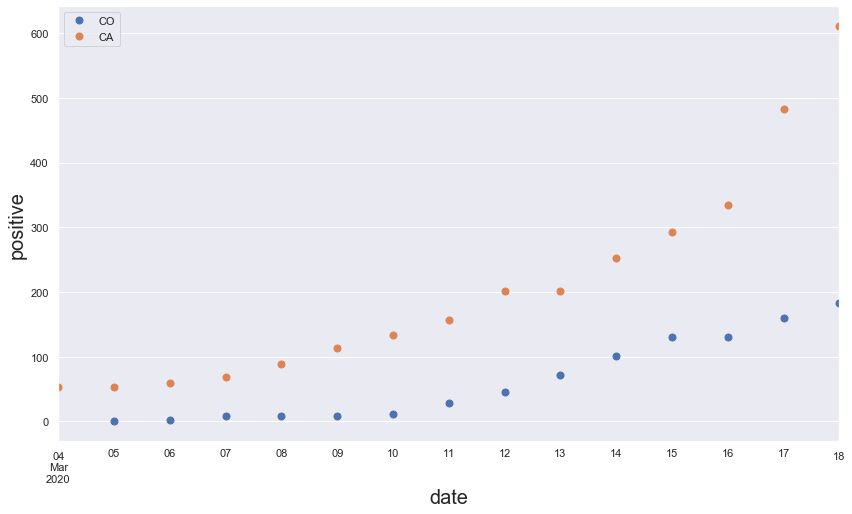

In [20]:
state_list = ['CO','CA']
indicator_list = ['positive']
plot_data(state_list,indicator_list)

## Functions necessary to plot both Data and Fit

In [21]:
#Growth used: Verhulst model. Explanation in COVID19_CompartmentalModels
def Verhulst(t, K, I0, r):
    return (K*I0*np.exp(r*t))/(K+I0*(np.exp(r*t)-1))

In [22]:
#Auxiliary function needed to take care of the datetime type of data in the plot
def Verhulst_toplot(dataframe,state_to_look,indicator_to_look,future_days=0):
    #Define the time_vector to map the datetime into a numpy array
    t_vec = time_vector(dataframe,state_to_look,future_days)
    
    url_paras = './Fit_Data/States/Verhulst_Parameters_{}.csv'.format(state_to_look)
    aux = pd.read_csv(url_paras)
    verhulst_paras = aux.set_index('indicator')
    
    K = verhulst_paras['K'][indicator_to_look]
    I0 = verhulst_paras['I0'][indicator_to_look]
    r = verhulst_paras['r'][indicator_to_look]
    
    #The optut is still a numpy array. The flip is necessary because of the way data are ordered
    return np.flip(Verhulst(t_vec,K,I0,r))

In [23]:
# Function to create the numpy array of times associated to the data. The time-scale is in days and the 
#order of time in the data is (top ---> bottom) = (more recent ---> older)
def time_vector(data_frame,state_to_look,future_days=0):
    time_frame = data_frame[data_frame.state==state_to_look]['date'].to_numpy()
    t_vec = np.zeros(len(time_frame))
    for k in range(len(time_frame)):
        t_vec[k] = ((time_frame[0]-time_frame[k]).item())/(np.power(10,9)*60*60*24)
    t_final = np.append(t_vec,np.linspace(t_vec[-1]+1,t_vec[-1]+future_days,num=future_days))
    return t_final

## Definition of plot functions

In [34]:
#Plots by indicator, for a list of regions specificed in region_list
def plot_fit_by_indicator(state_to_plot,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):
    for n in indicator_to_plot:
        plt.figure(figsize=(14,10))
        ax = plt.gca()
        t_indicator = PrettyTable(['Indicator = {}'.format(n), 'Value','Error'])
        dely_textbox = 0
        for k in state_list:
            #Upload the previously fitted data 
            url_paras = './Fit_Data/States/Verhulst_Parameters_{}.csv'.format(k)
            aux = pd.read_csv(url_paras)
            verhulst_paras = aux.set_index('indicator')
            
            #Define the subset of interest for the Data 
            df = covid19_USA[covid19_USA.state==k]
            
            #Creat a new dataframe with some "future_days" to continue the fit 
            old_time = df['date']
            date_zero = old_time.iloc[0]
            aux1 = pd.DataFrame([date_zero+datetime.timedelta(days=x) for x in range(1,1+future_days)])
            future_time = pd.DataFrame(np.flip(aux1.to_numpy()))
            new_time = pd.concat([future_time,old_time], ignore_index = True) 
            #Plot the fit
            ax.plot(new_time,Verhulst_toplot(covid19_USA,k,n,future_days),label='Fit_{}_{}'.format(k,n),linewidth=3)
            #Plot the data
            #ax.plot(df['date'],df[n],'o',markersize=12,label='Data_{}_{}'.format(k,n))
            df.plot(x='date',y=n,ax=ax,marker='o',markersize=12,label='Data_{}_{}'.format(k,n),linestyle='None')
            #df.plot(x='date',y=n,ax=ax,label=k,marker='o',linestyle='None')
            
            date_form = DateFormatter("%b-%d")
            ax.xaxis.set_major_formatter(date_form)
            
            ax.tick_params(labelsize=19)
            #Print a table with the fitted data
            t_indicator.add_row(['Carrying Capacity {}'.format(k),verhulst_paras['K'][n],verhulst_paras['delta_K'][n]])
            t_indicator.add_row(['Growth rate {}'.format(k),verhulst_paras['r'][n],verhulst_paras['delta_r'][n]])
            plt.yscale(y_scale)
            ax.legend(ncol=min(len(state_list),4), bbox_to_anchor=(0, 1),loc='lower left', fontsize=23)
            
            #Code to insert text with optimal value of the parameters
            textstr = '\n'.join((
                r'$K_\mathrm{{{}}}={{{:.0f}}} \pm {{{:.0f}}}$'.format(k,verhulst_paras['K'][n],verhulst_paras['delta_K'][n]),
                r'$r_\mathrm{{{}}}={{{:.3f}}} \pm {{{:.3f}}}$'.format(k,verhulst_paras['r'][n],verhulst_paras['delta_r'][n]) ))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.95-dely_textbox, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)
            dely_textbox = dely_textbox + 0.15
            
            
        print(t_indicator)
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(n,fontsize=23)
        if save_fig=='Yes':
            plt.savefig('./Plots/ByIndicator/{}_{}'.format(n,'_'.join(state_to_plot)))
    plt.show()

In [35]:
#Plots by state, for a list of regions specificed in region_list
def plot_fit_by_state(state_to_plot,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):
    for k in state_to_plot:
        plt.figure(figsize=(14,10))
        ax = plt.gca()
        t_indicator = PrettyTable(['State = {}'.format(k), 'Value','Error'])
        dely_textbox = 0
        for n in indicator_to_plot:
            #Upload the previously fitted data 
            url_paras = './Fit_Data/Indicators/Verhulst_Parameters_{}.csv'.format(n)
            aux = pd.read_csv(url_paras)
            verhulst_paras = aux.set_index('state')
            
            #Define the subset of interest for the Data 
            df = covid19_USA[covid19_USA.state==k]
            
            #Creat a new dataframe with some "future_days" to continue the fit 
            old_time = df['date']
            date_zero = old_time.iloc[0]
            aux1 = pd.DataFrame([date_zero+datetime.timedelta(days=x) for x in range(1,1+future_days)])
            future_time = pd.DataFrame(np.flip(aux1.to_numpy()))
            new_time = pd.concat([future_time,old_time], ignore_index = True) 
            #Plot the fit
            ax.plot(new_time,Verhulst_toplot(covid19_USA,k,n,future_days),label='Fit_{}_{}'.format(k,n),linewidth=3)
            #Plot the data
            df.plot(x='date',y=n,ax=ax,marker='o',markersize=12,label='Data_{}_{}'.format(k,n),linestyle='None')
            
            date_form = DateFormatter("%b-%d")
            ax.xaxis.set_major_formatter(date_form)
            
            ax.tick_params(labelsize=19)
            #Print a table with the fitted data
            t_indicator.add_row(['Carrying Capacity {}'.format(n),verhulst_paras['K'][k],verhulst_paras['delta_K'][k]])
            t_indicator.add_row(['Growth rate {}'.format(n),verhulst_paras['r'][k],verhulst_paras['delta_r'][k]])
            plt.yscale(y_scale)
            ax.legend(ncol=min(len(state_list),4), bbox_to_anchor=(0, 1),loc='lower left', fontsize=23)
            
            #Code to insert text with optimal value of the parameters
            textstr = '\n'.join((
                r"$K_\mathrm{{{}}}={{{:.0f}}} \pm {{{:.0f}}}$".format(n,verhulst_paras['K'][k],verhulst_paras['delta_K'][k]),
                r"$r_\mathrm{{{}}}={{{:.3f}}} \pm {{{:.3f}}}$".format(n,verhulst_paras['r'][k],verhulst_paras['delta_r'][k]) ))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.95-dely_textbox, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)
            dely_textbox = dely_textbox + 0.15
            
            
        print(t_indicator)
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(n,fontsize=23)
        if save_fig=='Yes':
            plt.savefig('./Plots/ByState/{}_{}'.format(k,'_'.join(indicator_to_plot)))
    plt.show()

## Usage of plot functions and arguments that can be used

- To plot federal data use 'USA' as name of the state
- plot_fit_by_state(state_to_plot,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):
- plot_fit_by_indicator(state_to_plot,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):

### Allowed arguments
- **state_list**: *list* - regions we are interested in - e.g. ['CA','CO']
- **indicator_list**: *list* - indicators we would like to look at - e.g. ['positive','death']
- **future_days**: *integer* - number of days you want to continue the fit to extract a future prediction
- **x_lim**: *list* of two non-negative *integers* - set the time-window of interest. The zero is the 24th of February - e.g. x_lim=[0,20]
- **y_lim**: *list* of two non-negative  *integers* - set the vertical window of interest. e.g. y_lim=[0,200]
- **y_scale**: choose the y-scale of the plot. Default is linear. e.g. y_scale='log'
- **save_fig** *string* can be either 'Yes', or 'No'. Default is no. Saves the plot in one of the two dedicated folders: Plots/ByRegion or Plots/ByIndicator

### Example 1: National data and fit on the number of people currently positive

+----------------------+---------------------+-----------------------+
| Indicator = positive |        Value        |         Error         |
+----------------------+---------------------+-----------------------+
| Carrying Capacity CA |  299999999.99862796 | 5.614876654271549e-13 |
|    Growth rate CA    | 0.19666201248896328 |  0.00982407674771657  |
| Carrying Capacity CO |  193.21541276329634 |   11.268587197889195  |
|    Growth rate CO    |  0.5679610273650931 |  0.05714063663266241  |
| Carrying Capacity NY |  299999999.95037043 | 1.312283387692038e-12 |
|    Growth rate NY    |  0.3798400776990835 |  0.015795240947135403 |
+----------------------+---------------------+-----------------------+


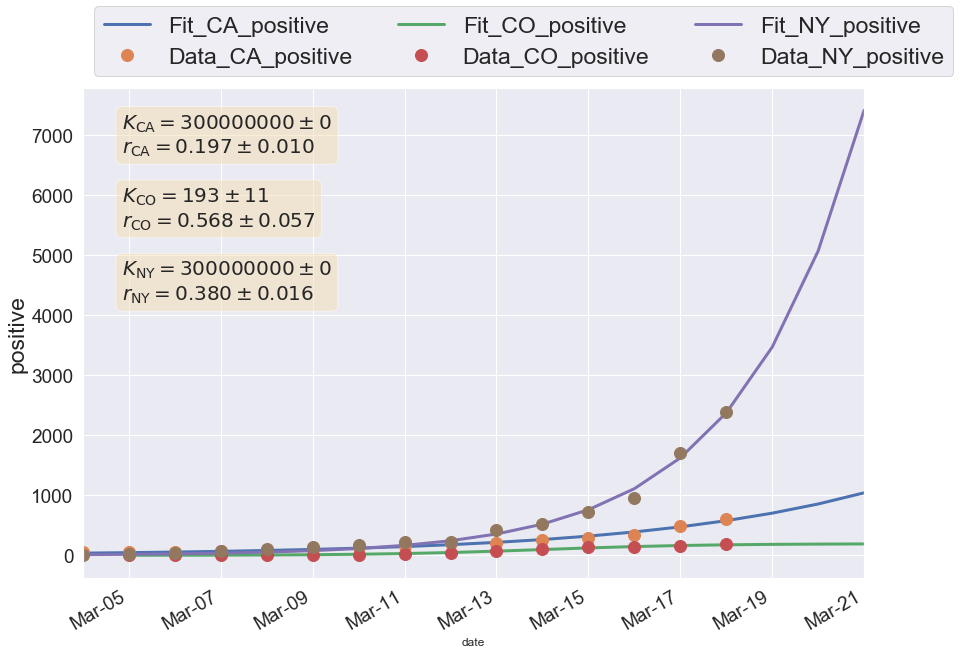

In [41]:
state_list=['CA','CO','NY']
indicator_list=['positive']
plot_fit_by_indicator(state_list,indicator_list,future_days=3,save_fig='Yes')

### Example 2: by state, number of confirmed positive cases in California and Colorado

+----------------------------+---------------------+-----------------------+
|         State = CA         |        Value        |         Error         |
+----------------------------+---------------------+-----------------------+
| Carrying Capacity positive |  299999999.99862796 | 5.614876654271549e-13 |
|    Growth rate positive    | 0.19666201248896328 |  0.00982407674771657  |
|  Carrying Capacity death   |  35525056.675501004 | 2.497530323365785e-16 |
|     Growth rate death      | 0.30670245121315226 |  0.03447714855074061  |
+----------------------------+---------------------+-----------------------+
+----------------------------+---------------------+-----------------------+
|         State = CO         |        Value        |         Error         |
+----------------------------+---------------------+-----------------------+
| Carrying Capacity positive |  193.21541276329634 |   11.268587197889195  |
|    Growth rate positive    |  0.5679610273650931 |  0.05714063663266241  |

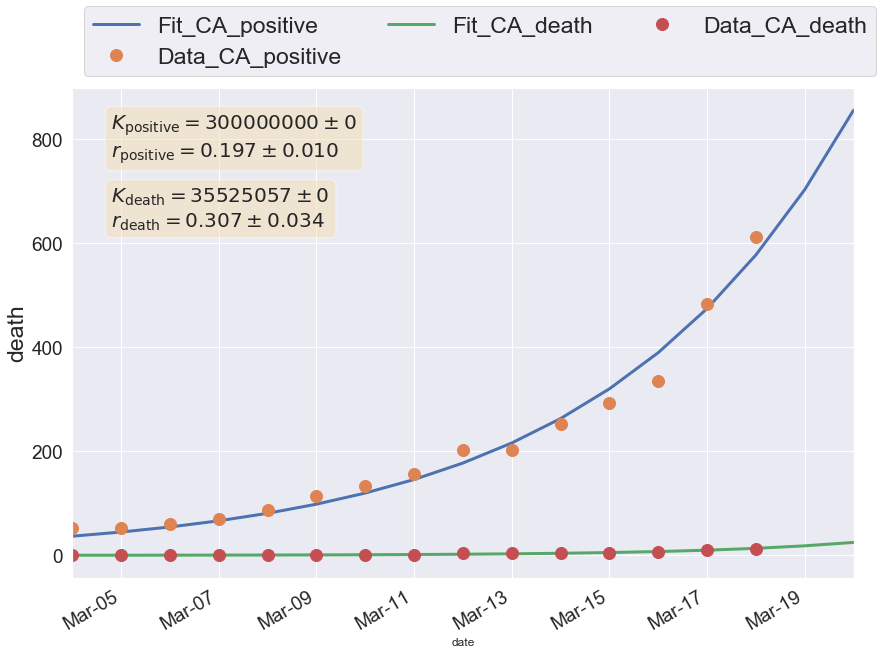

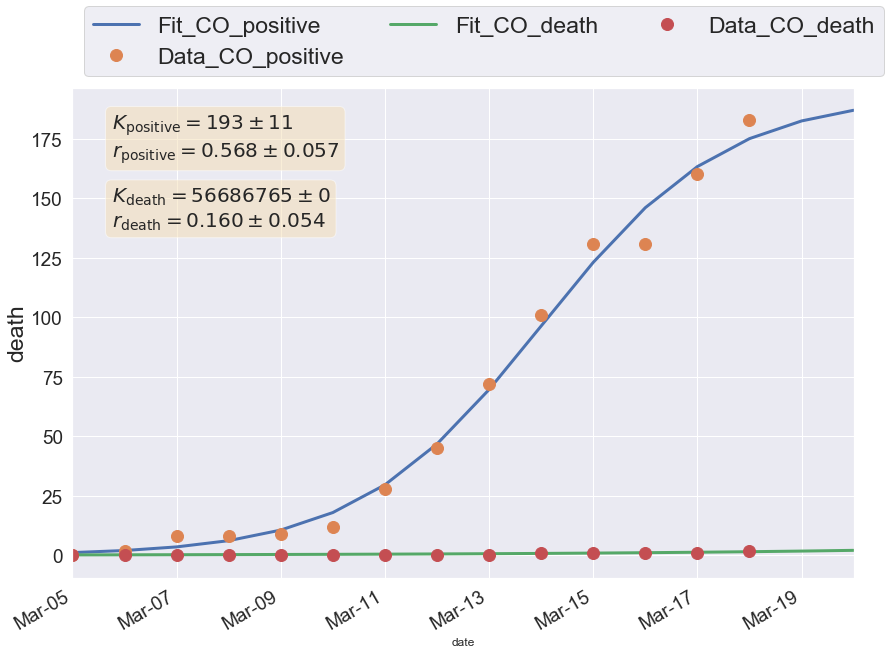

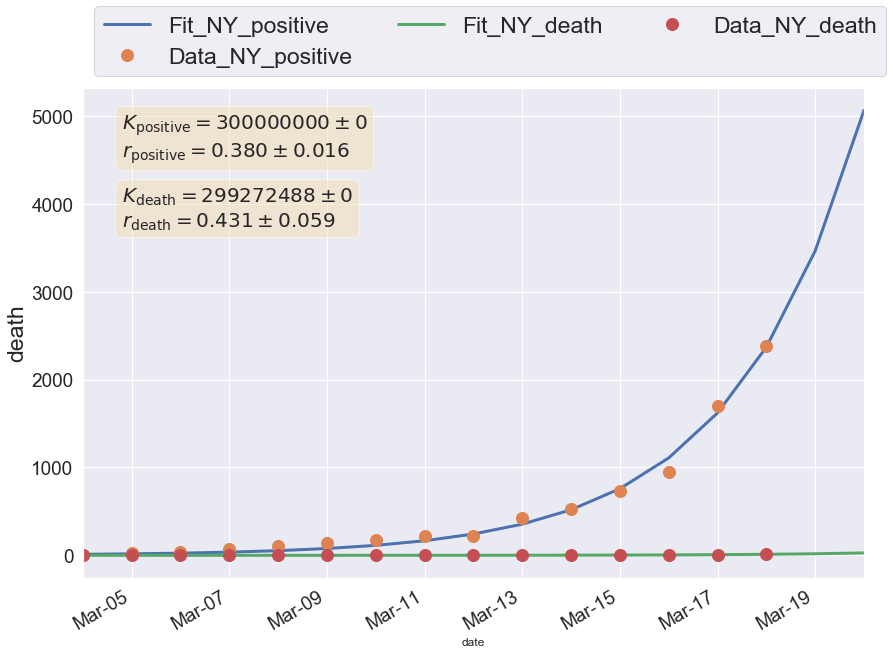

In [42]:
region_list=['CA','CO','NY']
indicator_list=['positive','death']
plot_fit_by_state(region_list,indicator_list,future_days=2,save_fig='Yes')